# Calibration

In [259]:
a = 0.4
b = 0.5 

beta = 0.35
alpha = 0.55

phi = 0.26
tau = 0.02

In [258]:
% reset -f
import scipy as sc
import numpy as np
import matplotlib.pyplot as plt
import sympy as sy



The agents' utility optimization problem is $$ max_{b,c} u(b,c) = b^{\alpha} c^{\beta}$$ w.r.t  $$ b + c \leq y $$ 
This yields the optimal solutions: $$b^* = \alpha y $$ and $$c^* = \beta y $$ 

In [266]:
def utility(beq, con):
    u = beq**a * con**b
    return u 
def optimal_bequest(inc):
    y = a * inc
    return y 
def optimal_consumption(inc):
    c = b * inc
    return c 

An enterpreneurs optimization problem in terms of labor supply is:
$$ max_n \Pi_i (k_i, x_i, w) = x_i k_{i}^\delta n_{i}^\gamma - wn_i $$
This yields: $$ n^* = (\frac{\beta x k^\alpha}{w})^{\frac{1}{1 - \beta}}  $$
Plugging this result into the profit function yields:
$$ \Pi_i (k_i, x_i, w) = (1- \beta) (x k^\alpha )^{\frac{1}{1 - \beta}} (\frac{\beta}{w})^{\frac{\beta}{1 - \beta}}  $$
The marginal return to capital is:
$$ \frac{\partial \Pi_i }{\partial k_i} = \alpha x^{\frac{1}{1-\beta}} k^{\frac{\alpha + \beta - 1}{1- \beta}} (\frac{\beta}{w})^{\frac{\beta}{1 - \beta} } $$


In [265]:
def Profit(talent, capital, wage):
    p = (1- beta)*(talent * capital**alpha)**(1/(1-beta)) * (beta/wage)**(beta/(1-beta)) 
    return p

def diff_Profit(talent,capital,wage):
    p = alpha * talent**(1/(1- beta)) * capital**((alpha + beta -1)/(1- beta)) * (beta/wage)**(beta/(1-beta))
    return p

Define $a$ as the amount invested by self-finance, i.e. by the bequest and $l$ as the amount of external finance. 
If an enterpreneur is unconstrained, i.e. he does not externally borrow as $a^* \leq b_i $, his optimization problem is:
$$max_a \Pi_i (a_i, x_i, w) = (1- \beta) (x_i a_{i}^\alpha )^{\frac{1}{1 - \beta}} (\frac{\beta}{w})^{\frac{\beta}{1 - \beta}}-(1+r)a_i  $$ w.r.t 
$$ a \leq b$$ 

$$ a^* =\left(x_i \left(\frac{\beta}{w} \right)^\beta \left(\frac{\alpha}{1+r} \right)^{1-\beta} \right)^{\frac{1}{1-\alpha-\beta}} $$ 

However, if $b < a^*$, the enterpreneurs optimization problem is:

$$max_{a,l} \Pi_i (a_i, l_i, x_i, w) = (1- \beta) (x_i (a_i + l_i)^\alpha )^{\frac{1}{1 - \beta}} (\frac{\beta}{w})^{\frac{\beta}{1 - \beta}} -(1+r)a_i - (1+r+ \tau)l_i$$

w.r.t

$$ (1+r+\tau)l_i \leq \phi \Pi_i (a_i, l_i, x_i, w) $$


In [264]:
def a_opt(talent, wage, interest_rate):
    p = (talent*(beta/wage)**beta * (alpha/(1 + interest_rate))**(1-beta))**(1/(1-alpha-beta))
    return p

For this simulation, we need to calibrate the talent and initial bequest distribution. The cumulative talent distribution is defined as $F(x) = x^{\frac{1}{4.422}}$. The initial bequest distribution is set to $0$.

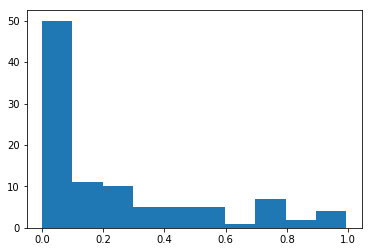

In [269]:

talents = []
talents = np.random.power((1/4.422),100)
bequests = []

for i in xrange(0,100):
    bequests.append(0.3)

plt.hist(talents)
plt.show()

In [270]:
def profit_unconstrained(talent, capital, wage, interest_rate):
    p = (1- beta)*((talent *  capital**alpha)**(1/(1-beta))) * ((beta/wage)**(beta/(1-beta))) - (1+ interest_rate)*capital
    return p


def optimal_capital_unconstrained(talent,  wage, interest_rate):
    q1 =  sc.optimize.fminbound(lambda capital: -profit_unconstrained(talent, capital, wage, interest_rate),0,1000)
    return q1

def optimal_profit_unconstrained(talent,  wage, interest_rate):
    p = ((1- beta)*(talent * optimal_capital_unconstrained(talent, wage, interest_rate)**alpha)**(1/(1-beta)) * (beta/wage)**(beta/(1-beta)) - (1+ interest_rate)*optimal_capital_unconstrained(talent, wage, interest_rate))
    return p

In [271]:

def Profit_constrained(cap, talent, wage, interest_rate):
    p = (1- beta) * (talent * (cap[0]+cap[1])**alpha)**(1/(1-beta)) * (beta/wage)**(beta/(1-beta)) - (1+interest_rate)*cap[0] - (1+interest_rate+tau)*cap[1]
    return p


def cons1(cap, bequest):
    p = bequest - cap[0] -  0*cap[1]
    return p 

def cons2(cap, talent, wage, interest_rate):
    p = (phi/(1+interest_rate+tau))*((1- beta) * (talent * (cap[0]+cap[1])**alpha)**(1/(1-beta)) * (beta/wage)**(beta/(1-beta)) - (1+interest_rate)*cap[0] - (1+interest_rate+tau)*cap[1]) -cap[1]
    return p
    
def cons3(cap, talent, wage, interest_rate):
    p = Profit_constrained(cap,talent, wage, interest_rate)
    return p

cons = ({'type': 'ineq', 'fun': lambda cap: np.array([cons1(cap,bequest)]),
                         'jac': lambda cap: np.array([-1, 0])},   
        {'type': 'ineq', 'fun': lambda cap: np.array([cons2(cap, talent, wage, interest_rate)]),
                         'jac': lambda cap: np.array([(phi/(1+interest_rate+tau))*jac1(cap, talent, wage, interest_rate),(phi/(1+interest_rate+tau))*jac2(cap, talent, wage, interest_rate)-1])},
        {'type': 'ineq', 'fun': lambda cap: np.array([cons3(cap, talent, wage, interest_rate)]),
                         'jac': lambda cap: np.array([jac1(cap, talent, wage, interest_rate),jac2(cap,talent, wage, interest_rate)])})

def jac1(cap, talent, wage, interest_rate,sign = 1.0):
    p = sign*alpha * talent**(1/(1-beta)) * (cap[0] + cap[1])**((alpha+beta-1)/(1-beta)) * (beta/wage)**(beta/(1-beta)) - (1+interest_rate)
    return p
    
def jac2(cap,talent,  wage, interest_rate,sign = 1.0):
    p = sign*alpha * (talent)**(1/(1-beta)) * (cap[0] + cap[1])**((alpha+beta-1)/(1-beta)) * (beta/wage)**(beta/(1-beta)) - (1+interest_rate+tau)
    return p 

def jac(cap, talent,wage, interest_rate):
    return np.array([jac1(cap,talent,  wage, interest_rate), jac2(cap,talent, wage, interest_rate)])

bnds = ((0, None), (0, None))
talent = 0.5
bequest = 0.5
wage = 0.01
interest_rate = 0.01

def optimal_profit_constrained(talent, wage, interest_rate):
    res =  sc.optimize.minimize(lambda cap: -Profit_constrained(cap,talent,wage,interest_rate),x0 = [2,2],constraints=cons, method='SLSQP',bounds = bnds)
    return Profit_constrained(res.x,talent,wage,interest_rate)

print(optimal_capital_unconstrained(0.35,0.01,0.01))
print(optimal_profit_constrained(0.4,0.01,0.01))

0.134643984959
0.0939651092131


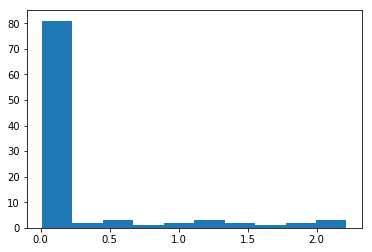

In [272]:
income = []
ent_unc_indicator = []
ent_con_indicator = []
wor_indicator =[]
ent_indicator = np.ones(100)

def income_loop(talents,wage,interest_rate):
    for i in xrange(len(talents)):
        if bequests[i] > a_opt(talents[i] , wage, interest_rate):
            income.append(optimal_profit_unconstrained(talents[i],wage,interest_rate))
            ent_unc_indicator.append(1)
            wor_indicator.append(0)
            ent_con_indicator.append(0)    
        else:
            bequest = bequests[i]
            income.append(optimal_profit_constrained(talents[i],wage,interest_rate))
            ent_con_indicator.append(1)
            ent_unc_indicator.append(0)
            wor_indicator.append(0)
    for i in xrange(len(talents)):
        if income[i] < wage:
            income[i] = wage
            ent_con_indicator[i] = 0
            ent_unc_indicator[i] = 0
            wor_indicator[i] = 1
            ent_indicator[i] = 0
    return income, wor_indicator, ent_con_indicator, ent_unc_indicator, ent_indicator

income, wor_indicator, ent_con_indicator, ent_unc_indicator, ent_indicator = income_loop(talents,0.01,0.01)

plt.hist(income)
plt.show()

In [311]:

def optimal_capital_constrained(talents, wage, interest_rate):
    res =  sc.optimize.minimize(lambda cap: -Profit_constrained(cap,talent,wage,interest_rate),x0 = [2,2], constraints=cons, method='SLSQP',bounds = bnds)
    return sum(res.x)

# print(optimal_capital_constrained(0.5,0.01,0.01))

def n_opt(talent, wage, cap_opt):
    p = ((beta*talent*cap_opt**alpha)/wage)**(1/(1-beta))
    return p 


labor_clearing = []
def labor_marketclearing(talents, wage, interest_rate):
    for i in xrange(len(talents)):
        p = wor_indicator[i] - ent_indicator[i]*n_opt(talents[i], wage , ent_con_indicator[i]*optimal_capital_constrained(talents[i],wage, interest_rate)+ ent_unc_indicator[i]*optimal_capital_unconstrained(talents[i],wage, interest_rate))
        labor_clearing.append(p)
    return sum(labor_clearing)

print(labor_marketclearing(talents, 0.07,0.03))


capital_clearing = []
def cap_marketclearing(talents, wage, interest_rate):
    for i in xrange(len(talents)):
        p = bequests[i] - ent_con_indicator[i]*optimal_capital_constrained(talents[i],wage, interest_rate) - ent_unc_indicator[i]*optimal_capital_unconstrained(talents[i],wage, interest_rate)
        capital_clearing.append(p)
    return sum(capital_clearing)

print(cap_marketclearing(talents,0.05,0.01))

def func(prices):
    wage = prices[0]
    interest_rate = prices[1]
    
    F = np.empty(2)
    F[0] = 0.5*cap_marketclearing(talents, wage, interest_rate)
    F[1] = 0.5*labor_marketclearing(talents, wage, interest_rate)
    return F

print(func([0.07,0.03]))
# sc.optimize.fsolve(lambda prices: func(talents,prices), x0 = (0.03,0.03))

sc.optimize.newton_krylov(func,[0.02, 0.02], method='lgmres', verbose=1)


70.2769451284
29.5945292173
[ 29.7420156   70.27694513]
0:  |F(x)| = 1521.75; step 1; tol 0.9999
1:  |F(x)| = 2867.13; step 1; tol 0.9999
2:  |F(x)| = 4212.54; step 1; tol 0.9999
3:  |F(x)| = 5557.95; step 1; tol 0.9999
4:  |F(x)| = 6903.37; step 1; tol 0.9999
5:  |F(x)| = 8248.79; step 1; tol 0.9999
6:  |F(x)| = 9594.21; step 1; tol 0.9999
7:  |F(x)| = 10939.6; step 1; tol 0.9999
8:  |F(x)| = 12285.1; step 1; tol 0.9999
9:  |F(x)| = 13630.5; step 1; tol 0.9999
10:  |F(x)| = 14975.9; step 1; tol 0.9999
11:  |F(x)| = 16321.3; step 1; tol 0.9999
12:  |F(x)| = 17666.7; step 1; tol 0.9999
13:  |F(x)| = 19012.2; step 1; tol 0.9999
14:  |F(x)| = 20357.6; step 1; tol 0.9999
15:  |F(x)| = 21703; step 1; tol 0.9999
16:  |F(x)| = 23048.4; step 1; tol 0.9999
17:  |F(x)| = 24393.9; step 1; tol 0.9999
18:  |F(x)| = 25739.3; step 1; tol 0.9999
19:  |F(x)| = 27084.7; step 1; tol 0.996547
20:  |F(x)| = 28430.1; step 1; tol 0.991635
21:  |F(x)| = 29775.5; step 1; tol 0.987198
22:  |F(x)| = 31121; step 

188:  |F(x)| = 254461; step 1; tol 0.909593
189:  |F(x)| = 255806; step 1; tol 0.909542
190:  |F(x)| = 257152; step 1; tol 0.909492
191:  |F(x)| = 258497; step 1; tol 0.909442
192:  |F(x)| = 259842; step 1; tol 0.909393
193:  |F(x)| = 261188; step 1; tol 0.909344
194:  |F(x)| = 262533; step 1; tol 0.909296
195:  |F(x)| = 263879; step 1; tol 0.909248
196:  |F(x)| = 265224; step 1; tol 0.909201
197:  |F(x)| = 266569; step 1; tol 0.909154
198:  |F(x)| = 267915; step 1; tol 0.909108
199:  |F(x)| = 269260; step 1; tol 0.909062
200:  |F(x)| = 270606; step 1; tol 0.909017
201:  |F(x)| = 271951; step 1; tol 0.908972
202:  |F(x)| = 273297; step 1; tol 0.908927
203:  |F(x)| = 274642; step 1; tol 0.908883
204:  |F(x)| = 275987; step 1; tol 0.908839
205:  |F(x)| = 277333; step 1; tol 0.908796
206:  |F(x)| = 278678; step 1; tol 0.908753
207:  |F(x)| = 280024; step 1; tol 0.908711
208:  |F(x)| = 281369; step 1; tol 0.908669
209:  |F(x)| = 282714; step 1; tol 0.908628
210:  |F(x)| = 284060; step 1; t

NoConvergence: [ 0.0219811  0.0177598]